### Version 10

In this version, I initially bumped up my alpha value but I actually saw a decline in performance. Then I decided to use default text preprocessor (commenting out my own preprocesser) and this time, the ROC result actually improved. Maybe the text preprocessing is not that important? Or am I just overfitting on my model? 

In [29]:
# all imports and magic commands
import re
# import regex
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# text preprocessing
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from part_of_speech import get_part_of_speech

from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [8]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [52]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    reviews = movie_data.review
#     lemmatizer = WordNetLemmatizer()
#     porter_stemmer=PorterStemmer()
 #https://kavita-ganesan.com/how-to-use-countvectorizer/#.YjpnbprMIqw   
#     def my_preprocessor(text):
#         text=text.lower() 
#         text=re.sub("<.*?>","",text)#remove html tag
#         text=re.sub("\\W"," ",text) # remove special chars
#         text=re.sub("\\s+(in|the|all|for|and|on)\\s+"," _connector_ ",text) # normalize certain words
    
    # stem words
    # words=re.split("\\s+",text)
    # stemmed_words=[porter_stemmer.stem(word=word) for word in words]

    # part_of_speech
    # lemmatization
#         tokenized_string = word_tokenize(text)
#         stemmed_words = [lemmatizer.lemmatize(token, get_part_of_speech(token)) for token in tokenized_string]
#         return ' '.join(stemmed_words)
    
#     print(my_preprocessor("<br>Testing if my_preprocessor worked?</br>"))
    print(movie_data.head(10))
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = CountVectorizer(ngram_range=(1,2))
        X_hv = hv.fit_transform(reviews)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(reviews)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    movie_data['word_count'] = reviews.str.split(' ').str.len()
    movie_data['punc_count'] = reviews.str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [53]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='../data/moviereviews_train.tsv', my_random_seed=73)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

        id  sentiment                                             review
0   5814_8          1  With all this stuff going down at the moment w...
1   2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2   7759_3          0  The film starts with a manager (Nicholas Bell)...
3   3630_4          0  It must be assumed that those who praised this...
4   9495_8          1  Superbly trashy and wondrously unpretentious 8...
5   8196_8          1  I dont know why people think this is such a ba...
6   7166_2          0  This movie could have been very good, but come...
7  10633_1          0  I watched this video at a friend's house. I'm ...
8    319_1          0  A friend of mine bought this film for £1, and ...
9  8713_10          1  <br /><br />This movie is full of references. ...
movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review  

# Fit (and tune) Various Models

#### Ridge Regression by Alpha Steps
https://www.mwbrady.com/post/ridgeregression/

In [54]:
from sklearn import linear_model

alphas = [1000,10000,15000,20000,100000,300000,500000]
rdgs = []
rdg_trainings = []
i=0;

for a in alphas:
    rdg = linear_model.RidgeClassifier(alpha=a)
    rdgs.append(rdg)

for rdg in rdgs:
    rdg.fit(X_train, y_train)
    rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, f"a-{alphas[i]}")
    rdg_performance_train.compute_measures()
    rdg_trainings.append(rdg_performance_train)
    i+=1

for training in rdg_trainings:
    print(training.performance_measures)

{'Pos': 10000, 'Neg': 10000, 'TP': 10000, 'TN': 10000, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'a-1000'}
{'Pos': 10000, 'Neg': 10000, 'TP': 10000, 'TN': 10000, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'a-10000'}
{'Pos': 10000, 'Neg': 10000, 'TP': 10000, 'TN': 10000, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'a-15000'}
{'Pos': 10000, 'Neg': 10000, 'TP': 10000, 'TN': 10000, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'a-20000'}
{'Pos': 10000, 'Neg': 10000, 'TP': 10000, 'TN': 10000, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'a-100000'}
{'Pos': 10000, 'Neg': 10000, 'TP': 10000, 'TN': 10000, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'a-300000'}
{'Pos': 10000, 'Neg': 10000, 'TP': 10000, 'TN': 10000, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'a-500000'}


### ROC plot to compare performance of various models and fits

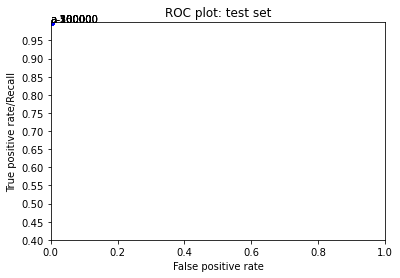

In [55]:
fits = rdg_trainings
    
fig = plt.subplots(figsize=(6, 4))

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0.4, 1])
plt.yticks(np.arange(0.4, 1, 0.05))
plt.title('ROC plot: test set')
plt.ylabel('True positive rate/Recall')
plt.xlabel('False positive rate')
plt.show()

### Create Pivot Table

In [56]:
fits = rdg_trainings

TP_rate =[]
FP_rate =[]

rows = []

for alpha in alphas:
    rows.append(f"a-{alpha}")

for fit in fits:
    FP_rate.append(fit.performance_measures['FP'] / fit.performance_measures['Neg'])
    TP_rate.append(fit.performance_measures['TP'] / fit.performance_measures['Pos'])
    
df = pd.DataFrame({"True Positive Rate":TP_rate, "False Positive Rate": FP_rate, "Rows": rows})
train_table = pd.pivot_table(df, values=["True Positive Rate","False Positive Rate"], index=["Rows"]).sort_values(by=['True Positive Rate'],ascending=False)

column_order=["True Positive Rate","False Positive Rate"]
train_table = train_table.reindex(column_order, axis=1)

print(train_table)

          True Positive Rate  False Positive Rate
Rows                                             
a-1000                   1.0                  0.0
a-10000                  1.0                  0.0
a-100000                 1.0                  0.0
a-15000                  1.0                  0.0
a-20000                  1.0                  0.0
a-300000                 1.0                  0.0
a-500000                 1.0                  0.0


---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: Ridge Regression by Alpha Steps

In [57]:
rdg_tests = []
i = 0;

for rdg in rdgs:
   
    rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, f"a-{alphas[i]}-test")
    rdg_performance_test.compute_measures()
    rdg_tests.append(rdg_performance_test)
    i +=1
    
for test in rdg_tests:
    print(test.performance_measures)

{'Pos': 2500, 'Neg': 2500, 'TP': 2312, 'TN': 2198, 'FP': 302, 'FN': 188, 'Accuracy': 0.902, 'Precision': 0.8844682478959449, 'Recall': 0.9248, 'desc': 'a-1000-test'}
{'Pos': 2500, 'Neg': 2500, 'TP': 2313, 'TN': 2199, 'FP': 301, 'FN': 187, 'Accuracy': 0.9024, 'Precision': 0.8848508033664881, 'Recall': 0.9252, 'desc': 'a-10000-test'}
{'Pos': 2500, 'Neg': 2500, 'TP': 2313, 'TN': 2200, 'FP': 300, 'FN': 187, 'Accuracy': 0.9026, 'Precision': 0.8851894374282434, 'Recall': 0.9252, 'desc': 'a-15000-test'}
{'Pos': 2500, 'Neg': 2500, 'TP': 2313, 'TN': 2201, 'FP': 299, 'FN': 187, 'Accuracy': 0.9028, 'Precision': 0.8855283307810107, 'Recall': 0.9252, 'desc': 'a-20000-test'}
{'Pos': 2500, 'Neg': 2500, 'TP': 2308, 'TN': 2207, 'FP': 293, 'FN': 192, 'Accuracy': 0.903, 'Precision': 0.8873510188389081, 'Recall': 0.9232, 'desc': 'a-100000-test'}
{'Pos': 2500, 'Neg': 2500, 'TP': 2295, 'TN': 2204, 'FP': 296, 'FN': 205, 'Accuracy': 0.8998, 'Precision': 0.8857583944423003, 'Recall': 0.918, 'desc': 'a-300000-t

### ROC plot to compare performance of various models and fits

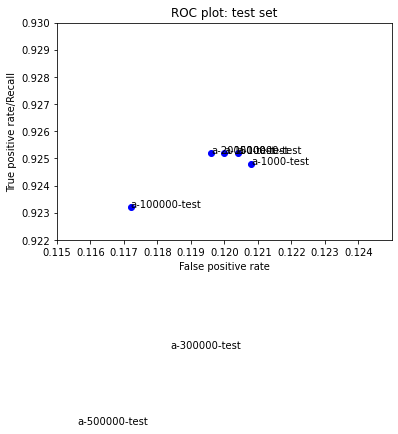

In [68]:
fits = rdg_tests
fig = plt.subplots(figsize=(6, 4))

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0.115, 0.125, 0.922, 0.930])
plt.yticks(np.arange(0.922, 0.930, 0.001))
plt.xticks(np.arange(0.115, 0.125, 0.001))
plt.title('ROC plot: test set')
plt.ylabel('True positive rate/Recall')
plt.xlabel('False positive rate')
plt.show()

### Create Pivot Table

In [66]:
fits = rdg_tests

TP_rate =[]
FP_rate =[]

rows = []
for alpha in alphas:
    rows.append(f"a-{alpha}")
    
for fit in fits:
    FP_rate.append(fit.performance_measures['FP'] / fit.performance_measures['Neg'])
    TP_rate.append(fit.performance_measures['TP'] / fit.performance_measures['Pos'])
    
df = pd.DataFrame({"True Positive Rate":TP_rate, "False Positive Rate": FP_rate, "Rows": rows})
test_table = pd.pivot_table(df, values=["True Positive Rate","False Positive Rate"], index=["Rows"]).sort_values(by=['True Positive Rate'],ascending=False)

column_order=["True Positive Rate","False Positive Rate"]
test_table = test_table.reindex(column_order, axis=1)

print(test_table)

          True Positive Rate  False Positive Rate
Rows                                             
a-10000               0.9252               0.1204
a-15000               0.9252               0.1200
a-20000               0.9252               0.1196
a-1000                0.9248               0.1208
a-100000              0.9232               0.1172
a-300000              0.9180               0.1184
a-500000              0.9152               0.1156


### looking at reviews based on their classification


---

# <span style="color:red">SUBMISSION</span>

---

In [23]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/home/ec2-user/data/moviereviews_test.tsv', my_random_seed=74, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         131           5
1         169          15
2         176          18
3         112           5
4         133           8
5         331          20
6         121          18
7         230          22
8          59           3
9         224          14
Size

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [24]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.5596


In [25]:
raw_data.head()

,id,review,word_count,punc_count
0,12311_10,Naturally in a film who's main themes are of m...,131,5
1,8348_2,This movie is a disaster within a disaster fil...,169,15
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18
3,7186_2,Afraid of the Dark left me with the impression...,112,5
4,12128_7,A very accurate depiction of small time mob li...,133,8


In [26]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,1
2,5828_4,1
3,7186_2,1
4,12128_7,0


In [27]:
my_submission.shape

(25000, 2)

In [28]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/home/ec2-user/data/moviereviews_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation